In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)

import xgboost as xgb
import shap

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load dataset
df = pd.read_csv("../data/german_credit_data.csv")
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [4]:
# Create target
df["loan_status"] = df["Risk"].map({"good": 0, "bad": 1})
df = df.drop(columns=["Risk"])

In [5]:
# One-hot encode
df_encoded = pd.get_dummies(df, drop_first=True)

In [6]:
# Features & target
X = df_encoded.drop("loan_status", axis=1)
y = df_encoded["loan_status"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [8]:
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    random_state=42,
    eval_metric="logloss"
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [9]:
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

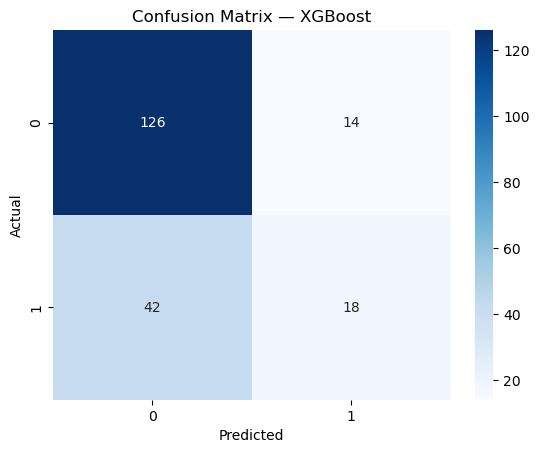

In [10]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — XGBoost")
plt.show()

In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.90      0.82       140
           1       0.56      0.30      0.39        60

    accuracy                           0.72       200
   macro avg       0.66      0.60      0.60       200
weighted avg       0.69      0.72      0.69       200



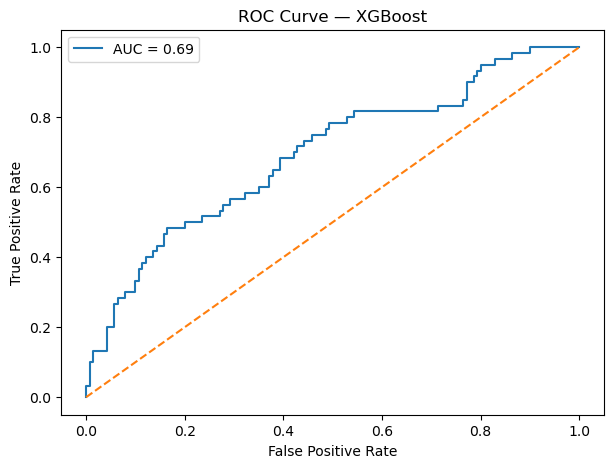

np.float64(0.6928571428571428)

In [12]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — XGBoost")
plt.legend()
plt.show()

auc_score

In [13]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer(X_test)

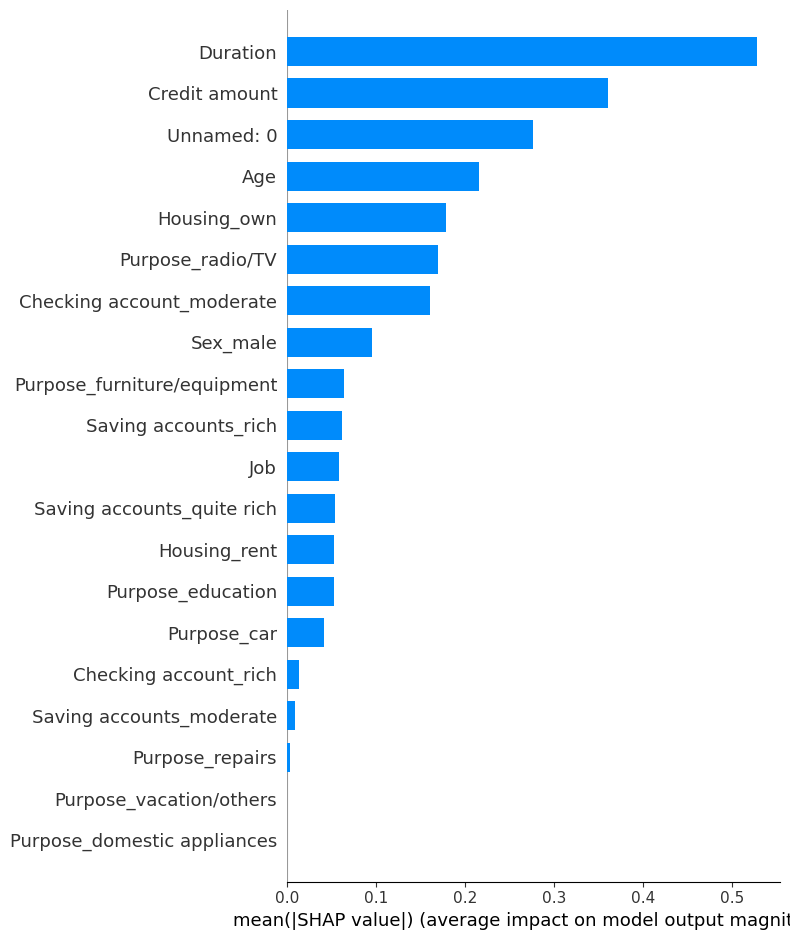

In [14]:
shap.summary_plot(shap_values.values, X_test, plot_type="bar")

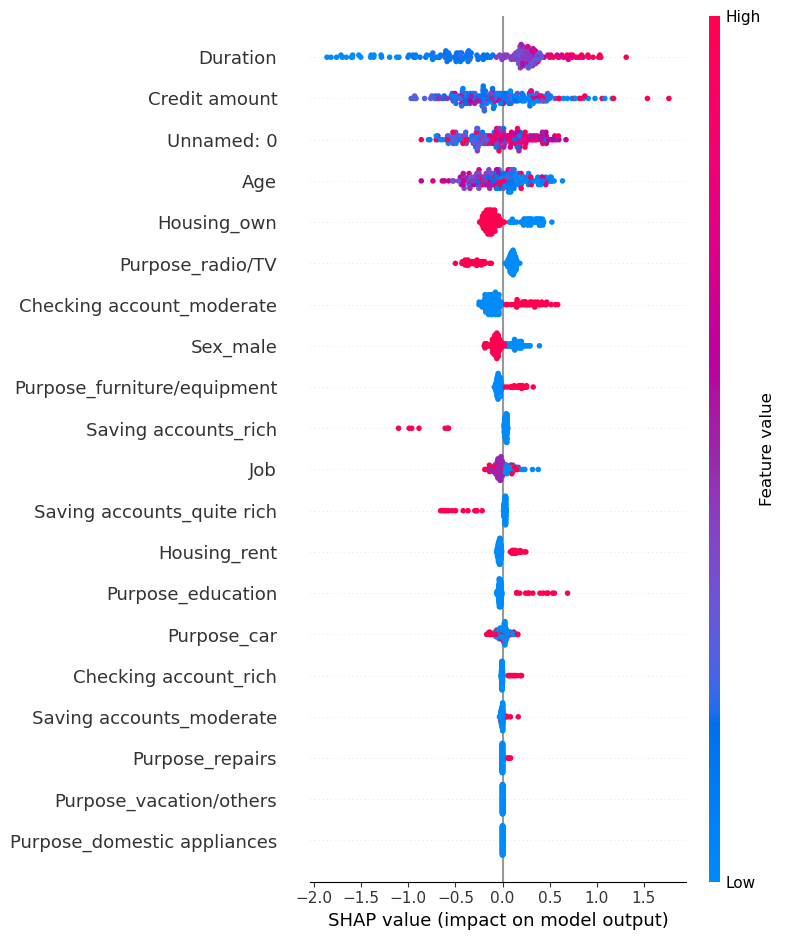

In [15]:
shap.summary_plot(shap_values.values, X_test)

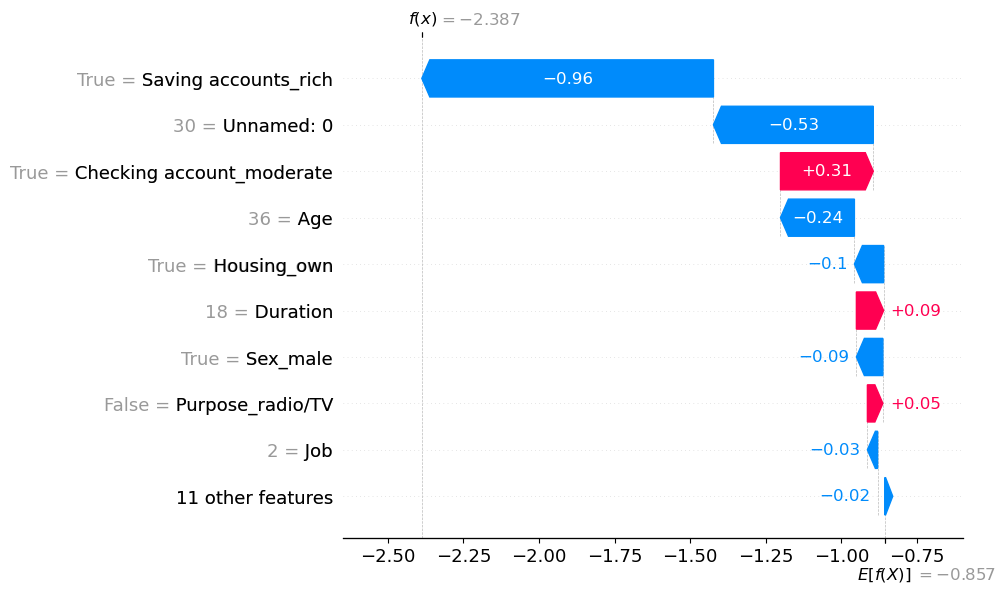

In [16]:
shap.plots.waterfall(shap_values[0])

In [17]:
import joblib
import os

os.makedirs("../models", exist_ok=True)

joblib.dump(xgb_model, "../models/xgboost_model.pkl")


['../models/xgboost_model.pkl']